In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

'''
# Any results you write to the current directory are saved as output.
from torch.utils.data import Dataset,DataLoader
import cv2
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm

ModuleNotFoundError: No module named 'cv2'

### Resize Images to train faster (save the time ;)

In [2]:
class Resize(object):
    def __init__(self,resize=64):
        self.resize = resize
    def __call__(self):
        
        !rm -r train_resized/dogs
        !rm -r train_resized/cats
        !rm -r test_resized/dogs
        !rm -r test_resized/cats
        !mkdir -p train_resized/dogs
        !mkdir -p train_resized/cats
        !mkdir -p test_resized/dogs
        !mkdir -p test_resized/cats
        
        for _class in ['cats','dogs']:
            
            for _type in ['training_set','test_set']:
                
                if 'train' in _type:
                    _type2 = 'train'
                else:
                    _type2 = 'test'
                
                path = os.path.join('/kaggle/input/cat-and-dog',_type,_type)
            
                _dir = os.path.join(path,_class)
                for root,_,fnames in sorted(os.walk(_dir,followlinks=True)):
                    for fname in fnames:
                        if '.jpg' in fname:
                            image = cv2.imread(os.path.join(_dir,fname))
                            image = cv2.resize(image,(self.resize,self.resize),interpolation=cv2.INTER_CUBIC)
                            result = cv2.imwrite(os.path.join(f'{_type2}_resized/{_class}',fname),image)
                            print('{} {} saved {}'.format(_type,_class,result))
            
                
                

In [3]:
resize = Resize()
resize()

rm: cannot remove 'train_resized/dogs': No such file or directory
rm: cannot remove 'train_resized/cats': No such file or directory
rm: cannot remove 'test_resized/dogs': No such file or directory
rm: cannot remove 'test_resized/cats': No such file or directory
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set cats saved True
training_set 

In [4]:
class CatDogDataset(Dataset):
    def __init__(self,_type='train_resized'):
        self.path = _type
        self.classes = {'cats':0,'dogs':1}
        self.samples = self.get_samples(self.classes)
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self,idx):
        image = self.samples[idx][0]
        image = cv2.imread(image)

        label = self.samples[idx][1]
        return image, label
        
        
    def get_samples(self,classes):
        images = []
        for i in sorted(classes.keys()):
            root = os.path.join(self.path,i)
            for root,_,fnames in sorted(os.walk(root,followlinks=True)):
                for fname in fnames:
                    if 'jpg' in fname:
                        item = (os.path.join(root,fname),classes[i])
                        images.append(item)

        return images

In [5]:
catdog = CatDogDataset()
catdog_images = DataLoader(catdog,batch_size=25,shuffle=True)

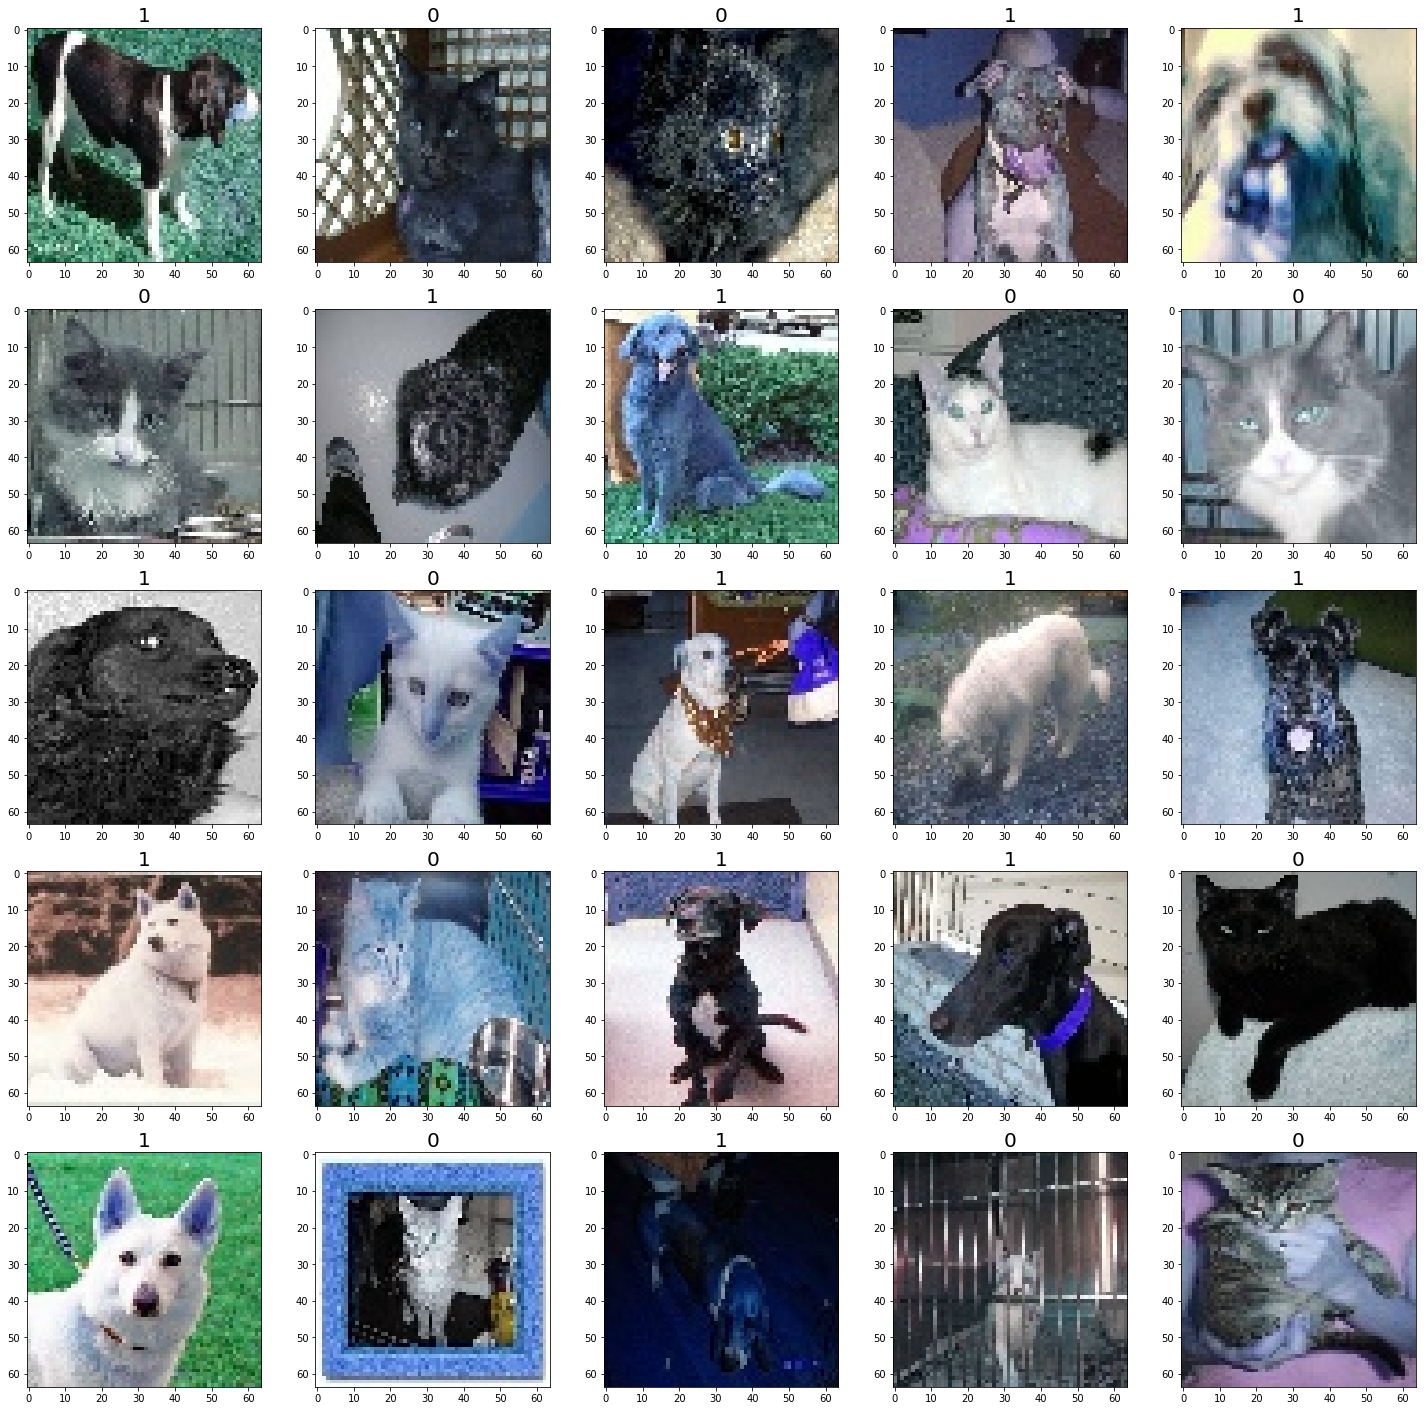

In [6]:
import matplotlib.pyplot as plt
b = next(iter(catdog_images))
figs, ax = plt.subplots(5,5,figsize=(25,25))
for i in range(25):
    j = i//5
    k = i%5
    ax[j,k].imshow(b[0][i])
    ax[j,k].set_title(f'{b[1][i]}',fontsize=20)

### Model ResNet34 slightly modified.

In [7]:
 class ResidualBlock(nn.Module):
        
        def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
            super().__init__()
            self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
            )
            self.conv2 = nn.Sequential(
                nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
                nn.BatchNorm2d(out_channels),
            )
            
            if stride!=1 or in_channels != out_channels:
                self.shortcut = nn.Sequential(
                    nn.Conv2d(in_channels,out_channels,kernel_size=1,stride = stride,bias=False),
                    nn.BatchNorm2d(out_channels))
            else:
                self.shortcut = nn.Sequential()
            
        def forward(self,x):
            residual = x
            x = self.conv1(x)
            x = self.conv2(x)
            x += self.shortcut(residual)
            x = nn.ReLU(inplace=True)(x)
            return x
            

In [8]:
class ResNet34(nn.Module):
    def __init__(self,n_classes):
        super().__init__()
        
        self.block1 = nn.Sequential(
            nn.Conv2d(3,64,7,2,3,bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.block2 = nn.Sequential(
            nn.MaxPool2d(3,2),
            ResidualBlock(64,64,1),
            ResidualBlock(64,64,1),
            ResidualBlock(64,64,1)
        )
        self.block3 = nn.Sequential(
            ResidualBlock(64,128,1),
            ResidualBlock(128,128,1),
            ResidualBlock(128,128,1),
            ResidualBlock(128,128,2)
        )
        self.block4 = nn.Sequential(
            ResidualBlock(128,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,1),
            ResidualBlock(256,256,2)
        )
        self.block5 = nn.Sequential(
            ResidualBlock(256,512,1),
            ResidualBlock(512,512,1),
            ResidualBlock(512,512,2)
        )
        self.avgpool = nn.AvgPool2d(2)
        self.fc = nn.Linear(512,n_classes)
        
    def forward(self,x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.block5(x)
        x = self.avgpool(x)
        x = x.view(x.size(0),-1)
        x = self.fc(x)
        
        return x

In [9]:
!pip install torchsummary
from torchsummary import summary
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ResNet34(2).to(device)
summary(model, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 15, 15]               0
            Conv2d-5           [-1, 64, 15, 15]          36,864
       BatchNorm2d-6           [-1, 64, 15, 15]             128
              ReLU-7           [-1, 64, 15, 15]               0
            Conv2d-8           [-1, 64, 15, 15]          36,864
       BatchNorm2d-9           [-1, 64, 15, 15]             128
    ResidualBlock-10           [-1, 64, 15, 15]               0
           Conv2d-11           [-1, 64, 15, 15]          36,864
      BatchNorm2d-12           [-1, 64, 15, 15]             128
             ReLU-13           [-1, 64, 15, 15]               0
           Conv2d-14           [-1, 64,

In [10]:
catdog = CatDogDataset()
train_loader = DataLoader(catdog,batch_size=25,shuffle=True)

In [11]:
model = ResNet34(2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 1e-4)
criterion = nn.CrossEntropyLoss(reduce='mean')
epochs = 20
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.train()
losses = []
accs = []
for epoch in range(epochs):
    
    print('epochs {}/{} '.format(epoch+1,epochs))
    running_loss = 0.0
    running_acc = 0.0
    for idx, (inputs,labels) in tqdm(enumerate(train_loader),total=len(train_loader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs.permute(0,3,2,1).float())
        loss = criterion(outputs,labels)
        running_loss += loss
        running_acc += (outputs.argmax(1)==labels).float().mean()
        loss.backward()
        optimizer.step()
        
    losses.append(running_loss/len(train_loader))
    accs.append(running_acc/len(train_loader))
    print('acc : {:.2f}%'.format(running_acc/len(train_loader)))
    print('loss : {:.4f}'.format(running_loss/len(train_loader)))

epochs 1/20 


/opt/conda/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



acc : 0.62%
loss : 0.6554
epochs 2/20 



acc : 0.72%
loss : 0.5515
epochs 3/20 



acc : 0.77%
loss : 0.4742
epochs 4/20 



acc : 0.82%
loss : 0.4033
epochs 5/20 



acc : 0.86%
loss : 0.3267
epochs 6/20 



acc : 0.89%
loss : 0.2624
epochs 7/20 



acc : 0.92%
loss : 0.2071
epochs 8/20 



acc : 0.93%
loss : 0.1627
epochs 9/20 



acc : 0.94%
loss : 0.1408
epochs 10/20 



acc : 0.95%
loss : 0.1237
epochs 11/20 



acc : 0.97%
loss : 0.0916
epochs 12/20 



acc : 0.97%
loss : 0.0893
epochs 13/20 



acc : 0.97%
loss : 0.0846
epochs 14/20 



acc : 0.97%
loss : 0.0783
epochs 15/20 



acc : 0.97%
loss : 0.0846
epochs 16/20 



acc : 0.98%
loss : 0.0680
epochs 17/20 



acc : 0.97%
loss : 0.0690
epochs 18/20 



acc : 0.98%
loss : 0.0593
epochs 19/20 



acc : 0.98%
loss : 0.0489
epochs 20/20 



acc : 0.98%
loss : 0.0559


Text(0.5, 1.0, 'train_acc')

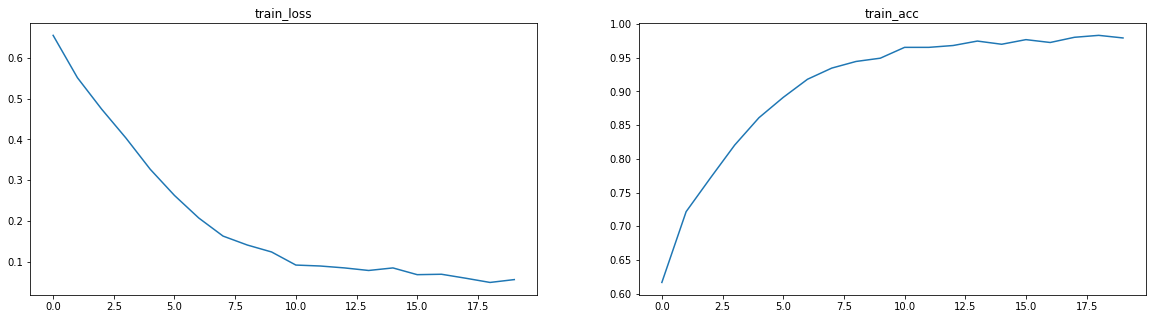

In [12]:
import matplotlib.pyplot as plt
figs , ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(losses)
ax[0].set_title('train_loss')
ax[1].plot(accs)
ax[1].set_title('train_acc')

In [13]:
!rm -r train_resized
!rm -r test_resized